In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 419 kB 2.1 MB/s 


In [3]:
import torch
import json
import torchvision
import torchmetrics
from torchmetrics.detection.mean_ap import MeanAveragePrecision

from torch.utils.data import Dataset, DataLoader 
from torchvision import models,transforms,datasets
from pycocotools.coco import COCO
from PIL import Image
import matplotlib.pyplot as plt
from pprint import pprint
import random
import os

import matplotlib.pyplot as plt
import numpy as np

from itertools import compress
import torch.optim as optim
import torch.nn as nn
from torch.optim import lr_scheduler
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [4]:
json_path = "/content/drive/MyDrive/Task_segmentation/More_data_train/More_guns_and knifes/more_json/more_guns_knife.json"


In [5]:
coco_obj = COCO(json_path)

new_json_dict = {}
clean_coco_annotation = []
clean_image_annotation = []
clean_categories = list(coco_obj.cats.values())


for img_id in range(len(coco_obj.imgs.keys())):
  image_ids = img_id+1
  annotation_ids = coco_obj.getAnnIds(image_ids)
  coco_annotation = coco_obj.loadAnns(annotation_ids)
  image_annotation = coco_obj.loadImgs(image_ids)
      
   
  for ann_idx, ann in enumerate(coco_annotation):
    
    bbox = ann['bbox']
    if bbox[0]<= bbox[2] and bbox[1]<=bbox[3]:
      clean_coco_annotation.append(ann)
      clean_image_annotation.append(image_annotation[0])
  
clean_image_annotation = list({v['id']:v for v in clean_image_annotation}.values())
new_json_dict["info"] = {"year": "2021","version": "1.0",}
new_json_dict["images"] = clean_image_annotation
new_json_dict["annotations"] = clean_coco_annotation
new_json_dict["categories"] = clean_categories

In [6]:
class Instance(Dataset):
  def __init__(self,json):
    super(Instance,self).__init__()
    self.json = json
    self.coco = COCO(self.json)
    self.ids  = list(sorted(self.coco.imgs.keys()))
    self.transforms = transforms.Compose([transforms.ToTensor()])
  
  def __getitem__(self, index):
    self.image_ids = self.ids[index]
    self.annotations_ids = self.coco.getAnnIds(self.image_ids)
    self.coco_annotation = self.coco.loadAnns(self.annotations_ids)
    self.image_annotation = self.coco.loadImgs(self.image_ids)

    self.image_name = self.image_annotation[0]['file_name']
    

    self.image_path = os.path.join("/content/drive/MyDrive/Task_segmentation/More_data_train/More_guns_and knifes/guns_and_knifes",self.image_name)
    self.pil_img = Image.open(self.image_path).convert('RGB')
    plt.imshow(self.pil_img)
    plt.show()

    boxes = []
    labels =[]
    masks = []
    for annotation in self.coco_annotation:
      bbox = annotation['bbox']
      # bbox = bbox+ [annotation['category_id']]
      boxes.append(bbox)

      label = annotation['category_id']
      labels.append(label)

      mask = self.coco.annToMask(annotation)
      masks.append(mask)
      image_id = annotation['image_id']

    masks_data = np.stack(masks)
    tensor_image = self.transforms(self.pil_img)
    fmask = torch.as_tensor(masks_data,dtype = torch.uint8)
    bboxes = torch.as_tensor(boxes, dtype=torch.float32)
    labels = torch.as_tensor(labels, dtype=torch.int64)

    # self.transformed_data = self.transforms(image = self.pil_img, bboxes= boxes, class_labels= labels, masks = masks)    
    # fmask = torch.as_tensor(self.transformed_data['masks'], dtype = torch.uint8)
    # bboxes = torch.as_tensor(self.transformed_data['bboxes'], dtype = torch.float32)
    # tensor_image = torch.as_tensor(self.transformed_data['image'])
    # labels = torch.as_tensor(self.transformed_data['class_labels'], dtype = torch.int64)
    # image_id = torch.as_tensor([image_id], dtype=torch.int64)
            
  
    targ = {} 
    targ['boxes'] = bboxes.unsqueeze(0)
    targ['labels'] = labels.unsqueeze(0)
    targ['masks'] = fmask.unsqueeze(0)

    return tensor_image, targ


  def __len__(self,):
    return len(self.ids)

In [7]:
# with open('/content/drive/MyDrive/Task_segmentation/More_data_train/More_guns_and knifes/More_Cleaned_data.json', 'w', encoding='utf-8') as f:
#     json.dump(new_json_dict,f)

In [8]:
json_path1 = "/content/drive/MyDrive/Task_segmentation/More_data_train/More_guns_and knifes/More_Cleaned_data.json"

In [9]:
data_set = Instance(json_path1)

loading annotations into memory...
Done (t=1.42s)
creating index...
index created!


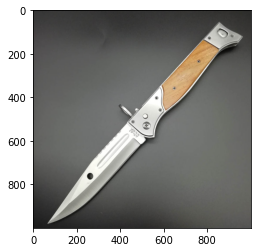

(tensor([[[0.1961, 0.1961, 0.1961,  ..., 0.1647, 0.1647, 0.1647],
          [0.1961, 0.1961, 0.1961,  ..., 0.1647, 0.1647, 0.1647],
          [0.2000, 0.1961, 0.1961,  ..., 0.1647, 0.1647, 0.1647],
          ...,
          [0.1059, 0.1059, 0.1059,  ..., 0.3255, 0.3255, 0.3255],
          [0.1059, 0.1059, 0.1059,  ..., 0.3294, 0.3294, 0.3294],
          [0.1059, 0.1059, 0.1059,  ..., 0.3294, 0.3294, 0.3294]],
 
         [[0.1961, 0.1961, 0.1961,  ..., 0.1647, 0.1647, 0.1647],
          [0.1961, 0.1961, 0.1961,  ..., 0.1647, 0.1647, 0.1647],
          [0.2000, 0.1961, 0.1961,  ..., 0.1647, 0.1647, 0.1647],
          ...,
          [0.1059, 0.1059, 0.1059,  ..., 0.3255, 0.3255, 0.3255],
          [0.1059, 0.1059, 0.1059,  ..., 0.3294, 0.3294, 0.3294],
          [0.1059, 0.1059, 0.1059,  ..., 0.3294, 0.3294, 0.3294]],
 
         [[0.1961, 0.1961, 0.1961,  ..., 0.1569, 0.1569, 0.1569],
          [0.1961, 0.1961, 0.1961,  ..., 0.1569, 0.1569, 0.1569],
          [0.2000, 0.1961, 0.1961,  ...,

In [10]:
data_set[50]

In [11]:
len(data_set)

118

In [12]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [13]:
model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained = True)
box_in_features = model.roi_heads.box_predictor.cls_score.in_features
mask_in_features = model.roi_heads.mask_predictor.conv5_mask.in_channels

num_classes = 2+1 # 1 for background
model.roi_heads.mask_predictor = MaskRCNNPredictor(mask_in_features, dim_reduced = 256, num_classes= num_classes)
model.roi_heads.box_predictor = FastRCNNPredictor(box_in_features, num_classes)

model

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


  0%|          | 0.00/170M [00:00<?, ?B/s]

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

In [14]:
def collate_fn(batch):
  return tuple(zip(*batch))



dl_train = DataLoader(data_set, batch_size= 2, shuffle=False, num_workers=4, collate_fn = collate_fn)
len(dl_train)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


59

In [16]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")
epochs = 100
lr = 0.005

model = model.to(device)
optimizer = torch.optim.SGD(model.parameters(),lr,momentum = 0.8)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)

train_losses = []

for epoch in range(epochs):
  print("Epoch",epoch)
  for i, data in enumerate(dl_train):
    inputs,label= data
   
    labels = [{k:v[0].to(device) for k,v in labels.items()} for labels in label]
    
    inputs = [input.to(device) for input in inputs]
    optimizer.zero_grad()
   
    loss_dict = model(inputs, labels)
    
    losses = sum([loss for loss in loss_dict.values()])
    print(losses)
    train_losses.append(losses.item())

    losses.backward()
    optimizer.step()
  scheduler.step()

Streaming output truncated to the last 5000 lines.
tensor(0.1660, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1873, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2033, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1937, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.4195, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3063, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2658, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2671, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1989, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2347, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1907, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.3935, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2615, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2493, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2474, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2014, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1766, device='cuda:0', grad_fn=<AddBackward0

In [17]:
torch.save(model,"/content/drive/MyDrive/Task_segmentation/More_data_train/More_guns_and knifes/best_model_more_data.bin")

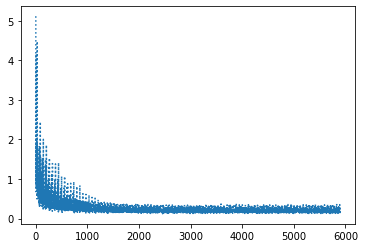

In [18]:
 
plt.plot(train_losses, linestyle = 'dotted')
plt.show()

In [ ]:
# model = torch.load("/content/drive/MyDrive/Task_segmentation/best_model.bin")

In [15]:
model = torch.load("/content/drive/MyDrive/Task_segmentation/More_data_train/More_guns_and knifes/best_model_more_data.bin",map_location ='cpu')


In [16]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

metric = MeanAveragePrecision()
test_losses = []



with torch.no_grad():
  for i,data in enumerate(dl_train):
      model = model.train().to(device) # IN TRAIN Mode

      inputs,label = data
      labels = [{k:v[0].to(device) for k,v in labels.items()} for labels in label]
      inputs = [input.to(device) for input in inputs]

      
      loss_dict = model(inputs, labels)
      losses = sum([loss for loss in loss_dict.values()])
      test_losses.append(losses.cpu().item())

      model = model.eval() # IN EVAL Mode
      output = model(inputs)

      metric.update(output, labels)
      

pprint(metric.compute())

{'map': tensor(0.5021),
 'map_50': tensor(0.7806),
 'map_75': tensor(0.5730),
 'map_large': tensor(0.5184),
 'map_medium': tensor(0.0668),
 'map_per_class': tensor(-1.),
 'map_small': tensor(-1.),
 'mar_1': tensor(0.5525),
 'mar_10': tensor(0.6728),
 'mar_100': tensor(0.6728),
 'mar_100_per_class': tensor(-1.),
 'mar_large': tensor(0.6864),
 'mar_medium': tensor(0.3300),
 'mar_small': tensor(-1.)}


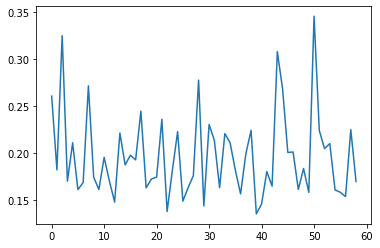

In [20]:
plt.plot(test_losses)
plt.show()

In [57]:
img = Image.open("/content/drive/MyDrive/Task_segmentation/00000010.png")
transforms = transforms.Compose([transforms.ToTensor()])

img_tensor = transforms(img)

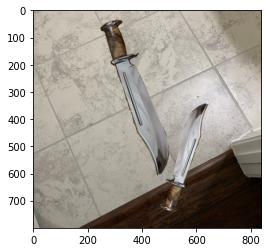

[{'boxes': tensor([[163.9304,  39.8696, 541.9922, 654.9151],
        [245.9514,   7.0699, 471.5391, 553.8609],
        [ 21.7825,  67.4185, 440.0023, 594.2354],
        [252.6780,  36.9361, 382.5682, 657.1332],
        [ 64.7066, 361.7713, 840.0000, 792.8516],
        [287.4795,  50.5044, 795.6809, 614.3578],
        [213.1703,  52.1391, 362.1485, 465.1293],
        [277.9635,  50.1712, 328.6164, 484.8093],
        [187.5271,   2.2950, 486.7823, 670.4984],
        [265.7689,  38.6121, 299.5046, 514.9337]], grad_fn=<StackBackward0>), 'labels': tensor([2, 2, 2, 2, 2, 2, 2, 2, 1, 2]), 'scores': tensor([0.5380, 0.3473, 0.1916, 0.1568, 0.1494, 0.1277, 0.1111, 0.0912, 0.0619,
        0.0604], grad_fn=<IndexBackward0>), 'masks': tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]],

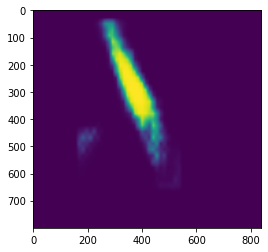

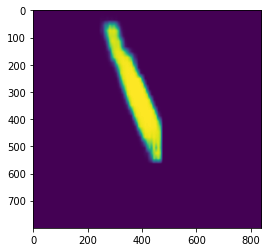

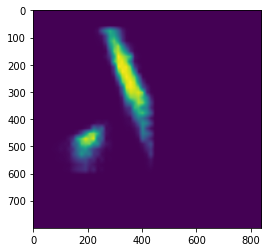

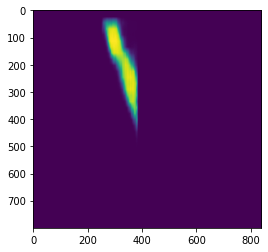

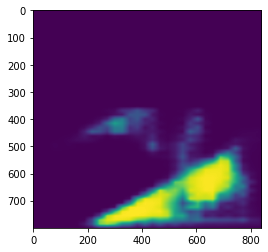

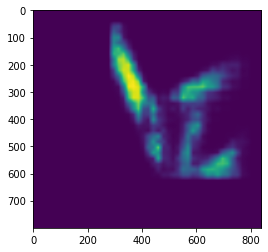

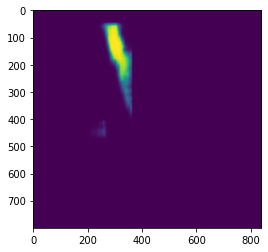

In [23]:
img = Image.open("/content/drive/MyDrive/Task_segmentation/00000010.png")
plt.imshow(img)
plt.show()
transforms = transforms.Compose([transforms.ToTensor()])

img_tensor = transforms(img)

model = model.eval() # IN EVAL Mode
output = model(img_tensor.to(device).unsqueeze(0))
print(output,"outpiursdhhd")



new_scores = output[0]['scores'][output[0]['scores'] > 0.10].detach().cpu()
new_boxes = output[0]['boxes'][output[0]['scores'] > 0.10].detach().cpu()
new_labels = output[0]['labels'][output[0]['scores'] > 0.10].detach().cpu()
new_masks = output[0]['masks'][output[0]['scores'] > 0.10].detach().cpu()

print(new_scores, new_boxes, new_labels, new_masks)

for s_mask in new_masks:
  plt.imshow(s_mask.squeeze())
  plt.show()

In [165]:
def random_colour_mask(image):
  colours = [
      [0,255,0],
      [0,0,255],
      [255,0,0],
      [255,255,0],
      [255,0,255],
      [80,70,180],
      [250,80,190],
      [245,145,50],
      [70,150,250],
      [50,190,190],
  ]
  r = np.zeros_like(image).astype(np.uint8)
  g = np.zeros_like(image).astype(np.uint8)
  b = np.zeros_like(image).astype(np.uint8)
  r[image == 1],g[image == 1],b[image == 1] = colours[random.randrange(0,10)]
  coloured_mask = np.stack([r,g,b],axis = 2)
  return coloured_mask

In [155]:
import cv2
from torchvision import models,transforms,datasets
img = Image.open("/content/drive/MyDrive/Task_segmentation/00000010.png").convert("RGB")
transforms = transforms.Compose([transforms.ToTensor()])

In [147]:
img_tensor = transforms(img)
model = model.eval()

output= model(img_tensor.to(device).unsqueeze(0))

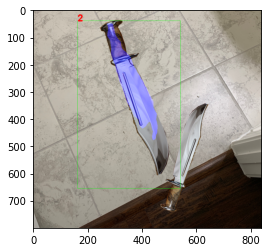

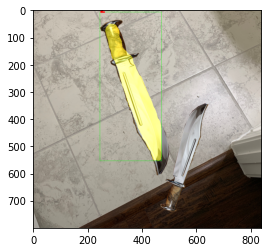

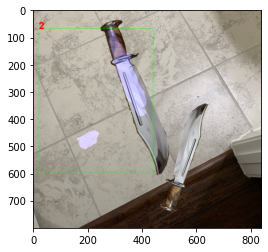

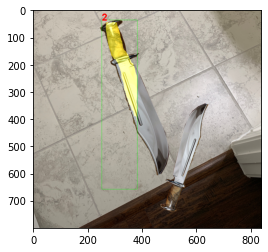

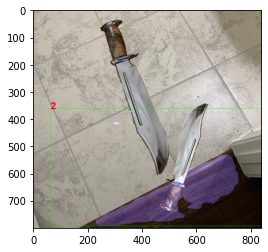

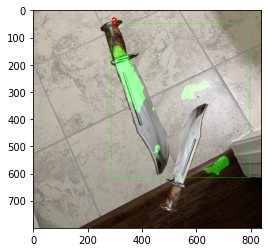

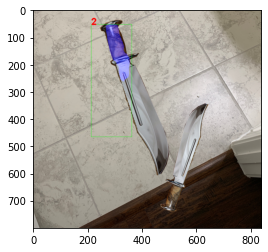

In [186]:
new_scores = output[0]['scores'][output[0]['scores'] > 0.10].detach().cpu()
new_boxes = output[0]['boxes'][output[0]['scores'] > 0.10].detach().cpu().numpy()
new_labels = output[0]['labels'][output[0]['scores'] > 0.10].detach().cpu().numpy()
new_masks = output[0]['masks'][output[0]['scores'] > 0.10].squeeze().detach().cpu().numpy()

for i in range(len(new_masks)):
  new_masks[i] = new_masks[i]>0.5
  rgb_mask = random_colour_mask(new_masks[i])
  
  np_img = np.array(img)
  np_img = cv2.addWeighted(np_img,1,rgb_mask,0.5,0)
  cv2.rectangle(
      np_img,
      (int(new_boxes[i][0]), int(new_boxes[i][1])),
      (int(new_boxes[i][2]), int(new_boxes[i][3])),
      color =(0,255,0),
      thickness =1,
  )
  cv2.putText(
      np_img,
      str(new_labels[i]),
      (int(new_boxes[i][0]), int(new_boxes[i][1])),
      fontFace = cv2.FONT_HERSHEY_SIMPLEX,
      fontScale = 1,
      color = (255,0,0),
      thickness=3,
  )
  plt.imshow(np_img)
  plt.show()

